In [26]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
import seaborn as sns
from scipy.interpolate import interp1d

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

# Read the pickled DataFrame
with open('data/consolidated_pat_tbl_tv.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
# OneHotEncode race (ethnicity)!
encoder = OneHotEncoder(sparse_output=False)
race_enc = encoder.fit_transform(consolidated_pat_tbl[['race']])
mod_df = consolidated_pat_tbl.drop('race' , axis = 1)
mod_df = pd.concat([mod_df , pd.DataFrame(
    race_enc , 
    columns = consolidated_pat_tbl[['race']].drop_duplicates().sort_values('race').values.T[0]
    )
] , axis = 1)

# OneHotEncode gender (sex)
gender_encoder = OneHotEncoder(sparse_output=False)
gender_enc = gender_encoder.fit_transform(mod_df[['gender']])
mod_df = mod_df.drop('gender' , axis = 1)
mod_df = pd.concat([mod_df , pd.DataFrame(
    gender_enc , 
    columns = consolidated_pat_tbl[['gender']].drop_duplicates().sort_values('gender').values.T[0]
    )
] , axis = 1)

In [3]:
def train_test_splitter_tv(df , test_size = 0.2 , val_size = 0.2 , patient_col = 'subject_id'):
    # get all patients
    pats = df[patient_col].unique()
    # inplace shuffle
    np.random.shuffle(pats)

    # get splits
    test_pats = pats[:int(test_size*len(pats))]
    val_pats = pats[int(test_size*len(pats)):int(test_size*len(pats))+int(val_size*len(pats))]
    train_pats = pats[int(test_size*len(pats))+int(val_size*len(pats)):]

    # allocate
    df_test = df[df['subject_id'].isin(test_pats)]
    df_val = df[df['subject_id'].isin(val_pats)]
    df_train = df[df['subject_id'].isin(train_pats)]
    
    # check
    assert df_train.subject_id.nunique() + df_test.subject_id.nunique() + df_val.subject_id.nunique() == df.subject_id.nunique()
    return df_train , df_test , df_val

df_train , df_test , df_val = train_test_splitter_tv(mod_df)

In [4]:
def feature_target_preprocess(df_original , subject_col , time_2_eve_col , event_col , timediff_col):
    df = df_original.copy()

    # cumulative time difference!
    df[timediff_col] = df.groupby(subject_col)[timediff_col].cumsum()

    target_cols = [time_2_eve_col , event_col]

    # feature cols
    x = df[[col for col in df.columns if col not in target_cols]]

    # get targets
    y = df[[subject_col]+target_cols].drop_duplicates().drop(subject_col, axis = 1)

    # Check
    assert x[subject_col].nunique() == len(y) , 'target and feature length mismatch' 
    assert x.shape[0] == df.shape[0] , 'row mismatch'
    return x , y

In [6]:
x_train , y_train = feature_target_preprocess(df_train , 'subject_id' , 'time_to_event' , 'death' , 'timediff')
x_test , y_test = feature_target_preprocess(df_test , 'subject_id' , 'time_to_event' , 'death' , 'timediff')
x_val , y_val = feature_target_preprocess(df_val , 'subject_id' , 'time_to_event' , 'death' , 'timediff')

In [7]:
def check_var(df):
    zero_var_cols = []
    # Check which columns have zero variance
    for _col in df.columns[:-2]:
        var = df[_col].var()
        if var == 0:
            zero_var_cols.append(_col)
    return zero_var_cols

# get rid of columns that have zero variance in training data as they won't add anything to the training
zero_var_cols = check_var(x_train)
print(f'zero_var_cols {zero_var_cols}')

# Drop the cols
_x_train = x_train.drop(zero_var_cols, axis = 1)
_x_test = x_test.drop(zero_var_cols, axis = 1)
_x_val = x_val.drop(zero_var_cols, axis = 1)

zero_var_cols ['candesartan', 'nicardipine']


In [104]:
%%time

def feature_reshape(df , subject_col , timediff_col , divisions):
    pats = list(df[subject_col].unique())

    # init container
    df_reshape = []

    # selecting individual patients in the df
    for pat in pats:
        pat_df = df[df[subject_col]==pat].fillna(method = 'ffill') # forward fill
        
        # Further Imputation
        imputer = SimpleImputer(strategy = 'most_frequent', keep_empty_features = True)
        imputed_pat_df = imputer.fit_transform(pat_df)
        _pat_df = pd.DataFrame(imputed_pat_df , columns = pat_df.columns)
        
        # quantized time difference
        timediff_div = np.linspace(
            _pat_df[timediff_col].min() , 
            _pat_df[timediff_col].max() ,
            divisions
        )

        # matrix to store patient features at timestamp-wise divisions of their history
        mat = []

        # interpolate
        _cols = [col for col in _pat_df.columns if col!='subject_id' and col!='timediff']
        for col in _cols:
            f = interp1d(_pat_df[timediff_col] , _pat_df[col]) # fit
            col_div = f(timediff_div)
            mat.append(col_div)
            
        mat = np.column_stack(mat)

        # add to container
        df_reshape.append(mat)

    arr = np.array(df_reshape, dtype = 'object').astype('float')
    arr = torch.Tensor(arr.reshape(arr.shape[0] , 1 , arr.shape[1] , arr.shape[2]))
    
    return arr

# Create variable length 3D representations
x_train_reshape = feature_reshape(
    _x_train , 
    subject_col = 'subject_id' , 
    timediff_col = 'timediff' , 
    divisions = 10
)

x_test_reshape = feature_reshape(
    _x_test , 
    subject_col = 'subject_id' , 
    timediff_col = 'timediff' , 
    divisions = 10
)

x_val_reshape = feature_reshape(
    _x_val , 
    subject_col = 'subject_id' , 
    timediff_col = 'timediff' , 
    divisions = 10
)

In [67]:
input = x_train_reshape.astype('float')
input = torch.Tensor(input.reshape(input.shape[0] , 1 , input.shape[1] , input.shape[2]))
print(input.shape)
c2d = nn.Conv2d(1 , 14 , kernel_size = 3)
# c2d(torch.Tensor(input))

torch.Size([3544, 1, 10, 43])


In [96]:
class Encoder(nn.Module):
    def __init__(self,hidden_dim: int = 10):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 14, kernel_size = 3 , stride = 1 , padding = 1)
        self.conv2 = nn.Conv2d(14, 7, kernel_size = 3, stride = 1 , padding = 1)
        self.act = nn.Tanh()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(7 * 10 * 43, hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() == 4

        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.act(x)
        return x

In [97]:
class Decoder(nn.Module):
    def __init__(self,hidden_dim: int = 10):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(hidden_dim, 7 * 10 * 43)
        self.flatten = nn.Flatten()
        self.act = nn.Tanh()
        self.conv1 = nn.Conv2d(7, 14, kernel_size = 3 , stride = 1 , padding = 1)
        self.conv2 = nn.Conv2d(14, 1, kernel_size = 3 , stride = 1 , padding = 1)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() == 2
        
        x = self.act(x)
        x = self.dense1(x)
        x = x.view(-1, 7, 10, 43) # inverse of flatten operation
        x = self.act(x)
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        return x

In [98]:
enc = Encoder()
dec = Decoder()
dec(enc(input)).shape , input.shape

(torch.Size([3544, 1, 10, 43]), torch.Size([3544, 1, 10, 43]))

In [102]:
class Autoencoder(nn.Module):
    def __init__(self,hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim)
        self.decoder = Decoder(hidden_dim)
        
    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() == 4
        
        encoding = self.encoder(x)
        decoding = self.decoder(encoding)
        return decoding , encoding

In [103]:
AE = Autoencoder()
AE(input)

(tensor([[[[ 0.0585,  0.0404,  0.0248,  ..., -0.0009, -0.0060, -0.0200],
           [ 0.1106,  0.0759,  0.0938,  ...,  0.0397,  0.0648, -0.0025],
           [ 0.0899,  0.0388,  0.0280,  ...,  0.0555,  0.0248, -0.0790],
           ...,
           [ 0.0260,  0.1313,  0.0366,  ..., -0.0088, -0.0009,  0.0543],
           [ 0.0697,  0.0488,  0.0549,  ...,  0.0546,  0.0533,  0.0395],
           [ 0.0825,  0.0727,  0.0656,  ...,  0.0387,  0.0390, -0.0710]]],
 
 
         [[[ 0.0628,  0.0507,  0.0359,  ...,  0.0163, -0.0024, -0.0164],
           [ 0.0986,  0.0775,  0.1155,  ...,  0.0373,  0.0988, -0.0129],
           [ 0.0982,  0.0130,  0.0179,  ...,  0.0328,  0.0165, -0.0790],
           ...,
           [ 0.0127,  0.1450,  0.0170,  ...,  0.0166,  0.0129,  0.0530],
           [ 0.0549,  0.0558,  0.0366,  ...,  0.0955,  0.0427,  0.0429],
           [ 0.0915,  0.0614,  0.0739,  ...,  0.0156,  0.0447, -0.0656]]],
 
 
         [[[ 0.0549,  0.0199,  0.0297,  ...,  0.0066, -0.0141, -0.0254],
       

In [117]:
# def create_distance_matrix(matrix_array):
#     distance_mtx = []
    
#     for i in range(matrix_array.shape[0]):
#         ssd = list(np.sum((matrix_array - matrix_array[i])**2 , axis = (1,2)))
#         frob = np.sqrt(ssd)
#         distance_mtx.append(frob)
    
#     return np.column_stack(distance_mtx)

# dm = create_distance_matrix(x_train_reshape)
# dm.shape

(27, 27)

C:\Users\soura\AppData\Local\Temp\ipykernel_368\1021413433.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method=linkage_method)


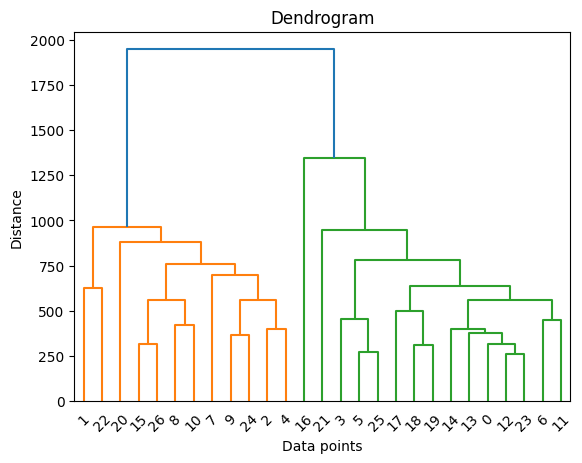

Data point clustering: [5 1 2 4 2 4 5 2 2 2 2 5 5 5 5 2 7 5 5 5 3 6 1 5 2 4 2]


In [119]:
# import numpy as np
# from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# import matplotlib.pyplot as plt

# # Step 1: Prepare the distance matrix
# # Replace this with your actual distance matrix
# distance_matrix = dm

# # Step 2: Choose the linkage method
# linkage_method = 'average'  # You can try 'single' or 'complete' as well

# # Step 3: Perform hierarchical clustering
# Z = linkage(distance_matrix, method=linkage_method)

# # Step 4: Determine the number of clusters using dendrogram
# dendrogram(Z)
# plt.xlabel('Data points')
# plt.ylabel('Distance')
# plt.title('Dendrogram')
# plt.show()

# # Step 5: Cut the dendrogram to get clusters
# num_clusters = 7 # You can adjust this based on the dendrogram visualization

# # Step 6: Assign data points to clusters
# clusters = fcluster(Z, num_clusters, criterion='maxclust')
# print("Data point clustering:", clusters)

In [30]:
def nan_check(arr):
    for i in range(len(arr)):
        s = np.isnan(arr[i]).sum()
        if s > 0:
            print(s)

nan_check(x_train_reshape)
nan_check(x_test_reshape)
nan_check(x_val_reshape)

In [9]:
# Pickle the DataFrame
with open('data/x_train_reshape_tv.pickle', 'wb') as file:
    pickle.dump(x_train_reshape, file)

with open('data/x_test_reshape_tv.pickle', 'wb') as file:
    pickle.dump(x_test_reshape, file)

with open('data/x_val_reshape_tv.pickle', 'wb') as file:
    pickle.dump(x_val_reshape, file)

# Pickle the targets
with open('data/y_train.pickle', 'wb') as file:
    pickle.dump(y_train, file)

with open('data/y_test.pickle', 'wb') as file:
    pickle.dump(y_test, file)

with open('data/y_val.pickle', 'wb') as file:
    pickle.dump(y_val, file)

### **JUNK**

In [10]:
# def feature_reshape(df, group_column = 0):
#     '''
#     Convert to 3D array
#     '''
#     # convert to numpy
#     df_arr = df.to_numpy()

#     # Step 1: Sort the array based on the group_column
#     sorted_data = df_arr[df_arr[:, group_column].argsort()]

#     # Step 2: Find unique values in the group_column
#     group_values, group_counts = np.unique(sorted_data[:, group_column], return_counts=True)

#     # Step 3: Use np.split() to split the sorted_data into separate arrays based on the unique values
#     grouped_data = np.split(sorted_data, np.cumsum(group_counts)[:-1])

#     # Step 4: Reshape the resulting arrays into a 3D matrix
#     result = np.array(grouped_data , dtype = 'object')

#     result_new = []

#     # # remove subject id
#     # for pat_img in result:
#     #     pat_img = pat_img[: , :-1]
#     #     result_new.append(pat_img)
    
#     # return np.array(result_new , dtype = 'object')
#     return np.array(result , dtype = 'object')

In [11]:
# # Create variable length 3D representations
# x_train_reshape = feature_reshape(x_train , group_column = -1)
# x_test_reshape = feature_reshape(x_test , group_column = -1)
# x_val_reshape = feature_reshape(x_val , group_column = -1)

In [ ]:
# def scaling(df):
#     # Scaling
#     scaler = StandardScaler()
#     scaled_columns = [
#     'cholesterol', 'sodium', 'lymphocyte', 'hemoglobin',
#     'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp','anchor_age','BMI (kg/m2)',
#     'Height (Inches)', 'Weight (Lbs)'
#     ]

#     unscaled_columns = ['acebutolol', 'amlodipine', 'atenolol', 'benazepril', 'candesartan',
#         'captopril', 'diltiazem', 'felodipine', 'irbesartan', 'lisinopril',
#         'moexipril', 'nadolol', 'nebivolol', 'nicardipine', 'nifedipine',
#         'olmesartan', 'propranolol', 'quinapril', 'ramipril', 'telmisartan',
#         'trandolapril', 'valsartan', 'verapamil', 'ASIAN', 'BLACK', 'HISPANIC', 'NATIVE',
#         'OTHER', 'WHITE' ,'F','M', 'subject_id','timediff']

#     # scale = [([col], StandardScaler()) for col in scaled_columns]
#     scale = [([col], None) for col in scaled_columns]
#     no_scale = [(col, None) for col in unscaled_columns]

#     x_mapper = DataFrameMapper(scale + no_scale)
    
#     # scale data
#     x = pd.DataFrame(x_mapper.fit_transform(df) , 
#                         columns = scaled_columns + unscaled_columns
#                         )
#     # add subject_id and timediff separately
    
#     # get targets
#     y = df[['subject_id','time_to_event','death']].drop_duplicates().drop('subject_id', axis = 1)

#     # Check
#     assert x.subject_id.nunique() == len(y) , 'target and feature length mismatch' 
#     assert x.shape[0] == df.shape[0] , 'row mismatch'
#     return x , y

# # Scale
# x_train , y_train = scaling(df_train)
# x_test , y_test = scaling(df_test)
# x_val , y_val = scaling(df_val)

In [ ]:
# # def null_masking(df):
# #     '''
# #     create a null mask
# #     '''
# #     mask = df.isnull().astype('int')
# #     mask.columns = [col+'_mask' for col in df.isnull().astype('int').columns]
# #     mask = mask.iloc[: , :-2]
# #     return mask

# # # Get masks
# # mask_train = null_masking(x_train)
# # mask_test = null_masking(x_test)
# # mask_val = null_masking(x_val)

# # # Add masks
# # _x_train = pd.concat([mask_train, x_train], axis = 1)
# # _x_test = pd.concat([mask_test, x_test], axis = 1)
# # _x_val = pd.concat([mask_val, x_val], axis = 1)

# _x_train = x_train
# _x_test = x_test
# _x_val = x_val